# **CRNN-Mb : A Multibranch CNN-RNN for ESC**
In this notebook, the implementation of CRNN-MB, a multi-branch multi-feature architecture combining a CNN and a RNN branch, is presented.   
Throughout the notebook, all implemented functions (except for the model's architecture) were organized into $4$ different Python modules:
- *data_helper.py*: contains the Clips class and all the functions used to handle data in the first stages of the project (functions to download the dataset, load it, organize it into folders, split it into train/test and data augmentation);
- *preprocess.py*: contains all the functions used for preprocessing, such as standardization, segmentation of the features and organization into folds;
- *train_test_model.py*: contains the functions used to train the models, as well as the functions implemented to aggregate predictions and compute per-class accuracy in the test stage;
- *plot_utils.py*: contains all the functions related to visualization, from the first stages to the final models comparison.
    

    
The Notebook is organized as follows:
1. **Download and organize data**: data is loaded, split into train/test and the features of some clips are visualized;
2. **Preprocessing**: data is augmented, standardized and segmented.
3. **Preliminary architecture experiments**: the multi-branch architecture is compared with a Sequential architecture;
4. **Tuning parameters**: different versions of the multi-branch architecture are trained by tuning number of dense hidden units and GRU bi-directionality.
5. **Final Tests**: the trained models are compared through various metrics.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd '/content/drive/MyDrive/MLHD_labs/Project_backup/Final_proj'

/content/drive/MyDrive/MLHD_labs/Project_backup/Final_proj


In [3]:
pip install pydub

In [4]:
from data_helper import *
from plot_utils import *
from preprocess import *
from train_test_model import *
import numpy as np
import tensorflow as tf
import pickle
import gc
import time
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from collections import Counter

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb
sb.set(style="white", palette="muted")

import pandas as pd
import random
random.seed(20150420)


In [5]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# 1. **Download and organize data**
In the following sections the function from the *data_helper.py* module are used in order to  download the ESC-50 dataset and organize all audio clips into sub-folders.
From the whole dataset ($2000$ clips), $25\%$ is retained and separately saved into the 'TEST_50' folder, to be used later in the testing phase.    

The rest of the dataset is then loaded into `clips_50`; the list is constitued of Clips object, as defined in the *preprocess.py* module.

## 1.1 Preparing data

In [ ]:
# Download all the dataset, in a folder called 'ESC-dataset'
download_dataset('ESC-50')

# Create 'esc10' and 'esc50' folders, each with subfolders organized per category (useful to use the Clips class)
organize_dataset('ESC-dataset', 'esc50')
organize_dataset('ESC-dataset', 'esc10')

In [ ]:
# Hold out a subset from the dataset, and move files to the TEST folder
create_test_dataset(name='esc50', test_dir='TEST_50')

# Load the train/validation dataset into a list of Clip objects
clips_50 = load_dataset('esc50')
# Load the test dataset into a list of Clips object, for size check
test_50 = load_dataset('TEST_50')

print('Test dataset size: {0},  Train dataset size = {1}'.format(len(test_50),len(clips_50)))

Test files moved to: TEST_50
All esc50 recordings loaded.
All TEST_50 recordings loaded.
Test dataset size: 500
Train dataset size = 1500.


## 1.2 Visual exploration
In this section , some of the functions implemented by Piczak et. al. are approprialy modified and employed to visulaize the raw audio waveform, the log-scaled Mel spectrogram and the MFCC. All the functions for this subsection belong to the *plot_utils.py* module.

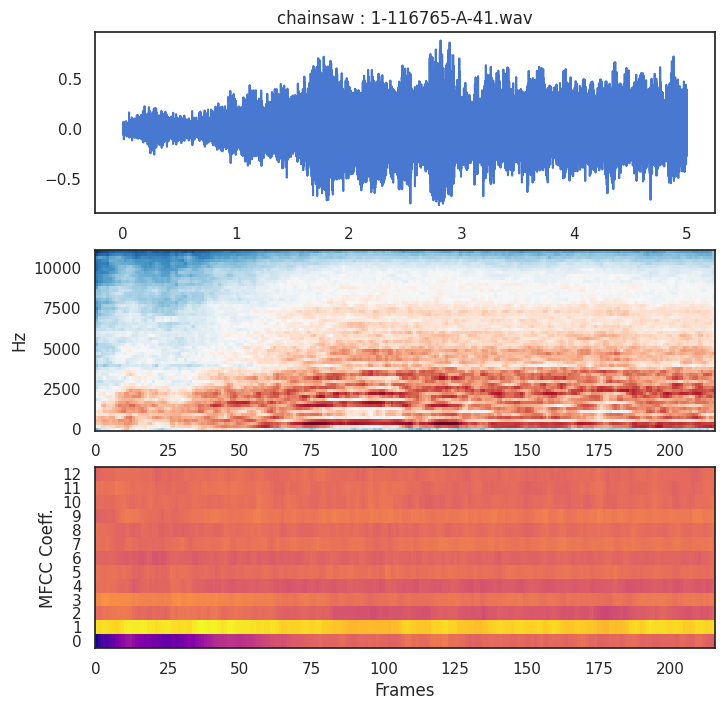

In [ ]:
# Visual exploration of one of the samples: raw waveform, log-scaled mel spectrogram and the first 13 MFCCs are plotted
clip = clips_50[180]
plt.figure(figsize=(8, 8))
with clip.audio as audio:
    plt.subplot(3, 1, 1)
    plt.title('{0} : {1}'.format(clip.category, clip.filename))
    plt.plot(np.arange(0, len(audio.raw)) / 22050.0, audio.raw)

    plt.subplot(3, 1, 2)
    librosa.display.specshow(librosa.power_to_db(clip.melspectrogram), sr=22050, x_axis='frames', y_axis='linear', cmap='RdBu_r')

    plt.subplot(3, 1, 3)
    librosa.display.specshow(clip.mfcc.T, x_axis="frames", sr=Clip.RATE, cmap="plasma")
    plt.ylabel("MFCC Coeff.")
    plt.yticks(np.arange(13), labels=np.arange(clip.mfcc.shape[1]))


IPython.display.Audio(filename=clip.path, rate=Clip.RATE)

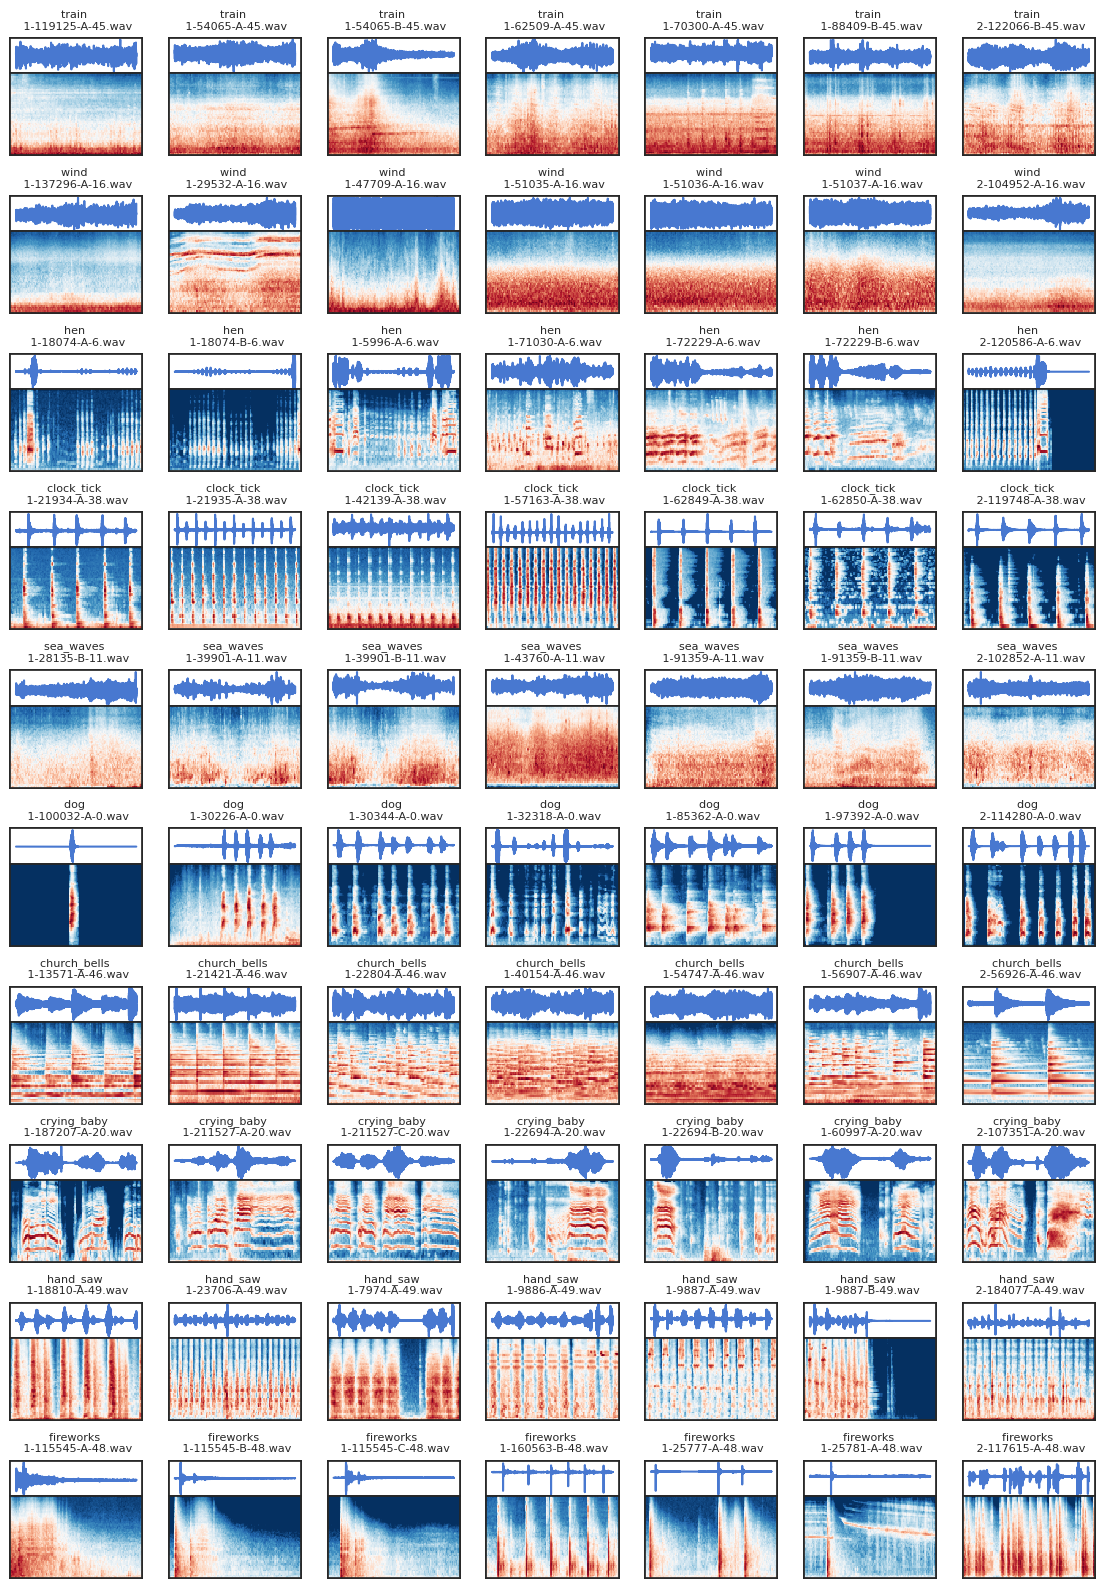

In [ ]:
# Melspectrograms over some of the classes
clips_overview(feature='melspec', categories=10, clips_shown=7, clips_list = clips_50)

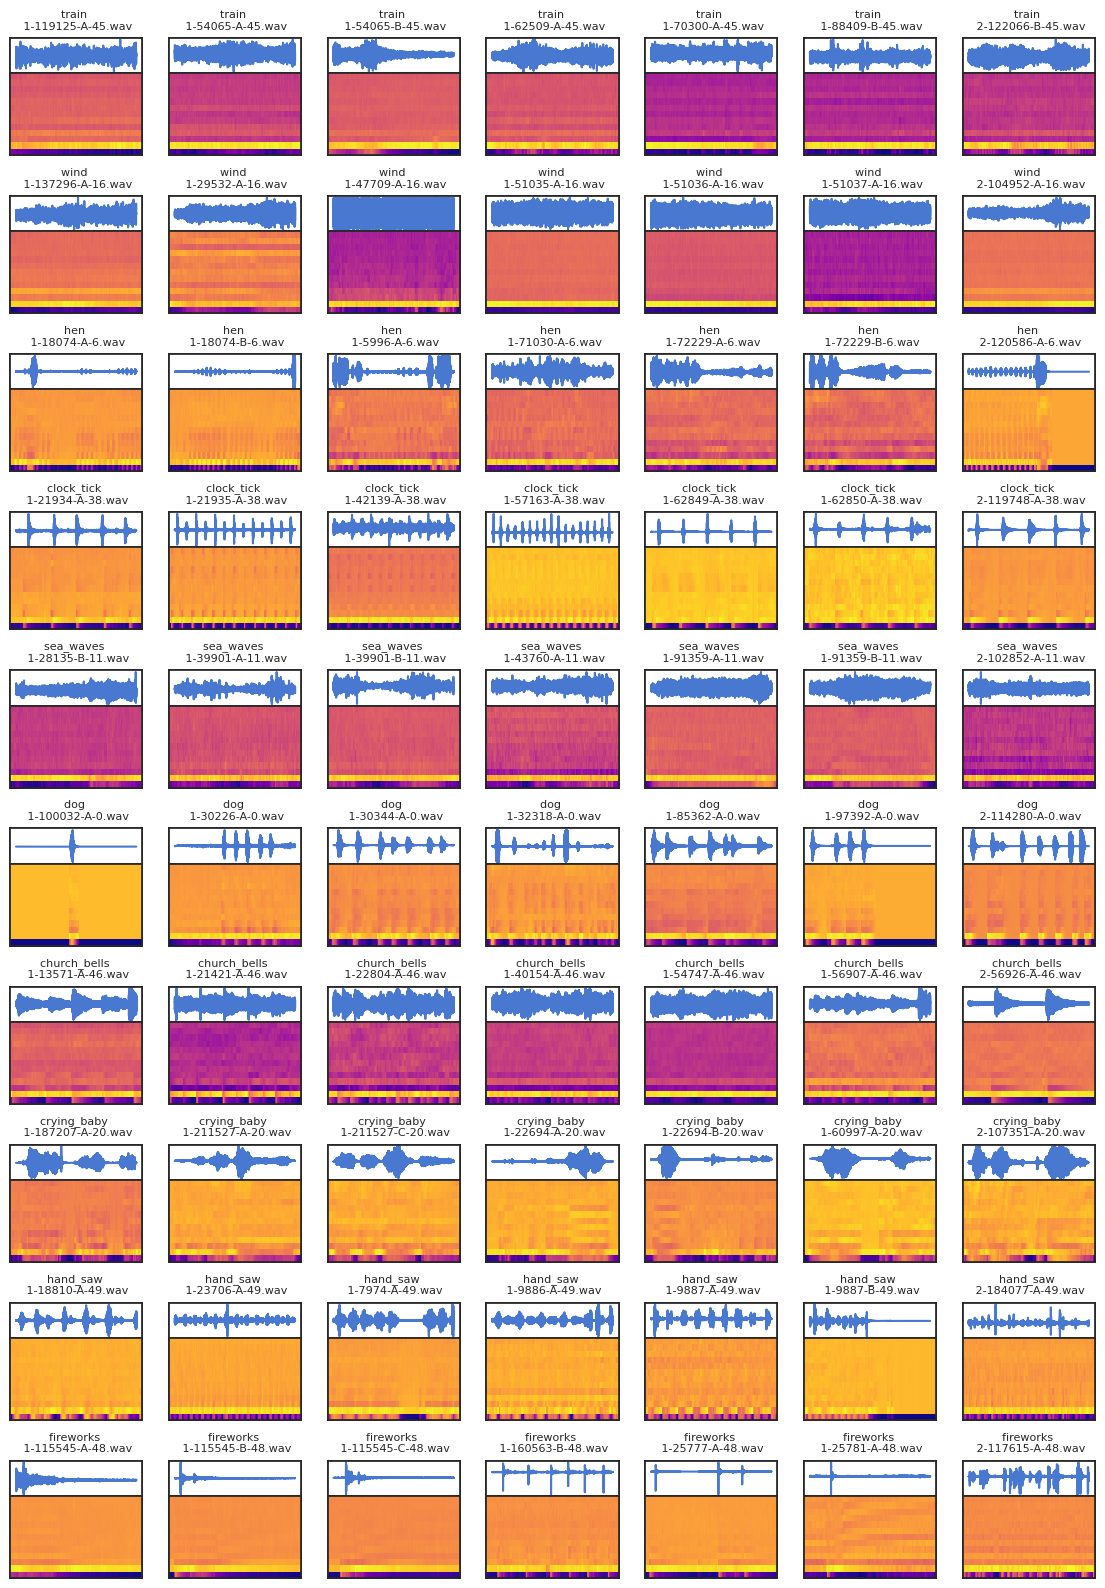

In [ ]:
# Mfcc over some of the classes
clips_overview(feature='mfcc', categories=10, clips_shown=7, clips_list = clips_50)

# 2. **Preprocessing**
The following section consists of all the preprocessing steps:
- **Data augmentation** : 4 augmentations per Clip, through time-shifting, pitch-shifting and time-delay (implementation in *data_helper.py*);
- **Segmentation** : for each Clip, standardized spectral features (log-Mel spectrograms, Deltas and MFCCs) are computed through the Clips class, and subdivided into $3$ shorter segments of length $101$ and $50\%$ overlap, to further enhance the number of samples available for training.
- **Fold subdivision** : since the original dataset provided a 5-fold subdivision of the dataset, in this phase the segmented dataset is organized in folds in order to make it easier to decide qhich folds to use for train and validation.

All these processes, of which the implementation can be seen in the *preprocess.py* module (except the data augmentation), are illustrated here singularly.    
Later on in the implementation, I found it more practical to have most of them them be carried out one after the other through a single function (*process_pipeline*) belonging to the same module, but I decided to keep this part of the code for clarity about what each function does.

## 2.1 Data augmentation

In [ ]:
print('Files before data augmentation: {0}'.format(len(clips_50)))

#Augmentation
augment_dataset(clips_50, is_10=False)
# Load augmented dataset
clips_50_aug = load_dataset('esc50')

print('Files after data augmentation: {0}'.format(len(clips_50_aug)))

Files before data augmentation: 1500
All esc50 recordings loaded.
Files after data augmentation: 7500


In [ ]:
# Save test dataset and train dataset to pickle files
with open("clips_50_aug.pkl", "wb") as f:
    pickle.dump(clips_50_aug, f)

with open("test_50.pkl", "wb") as ft:
    pickle.dump(test_50, ft)

### 2.1.1 Visualizing data augmentation

In this subsection, an example of what each technique of data augmentation does can be seen for a single clip.    
The functions below are implemented in the *plot_utils.py* module.

In [ ]:
# Load augmented Clips from pickle file
with open("clips_50_aug.pkl", "rb") as f:
    clips_50_aug = pickle.load(f)

In [ ]:
augmented_clips_dict = create_augmented_dict(clips_50_aug)

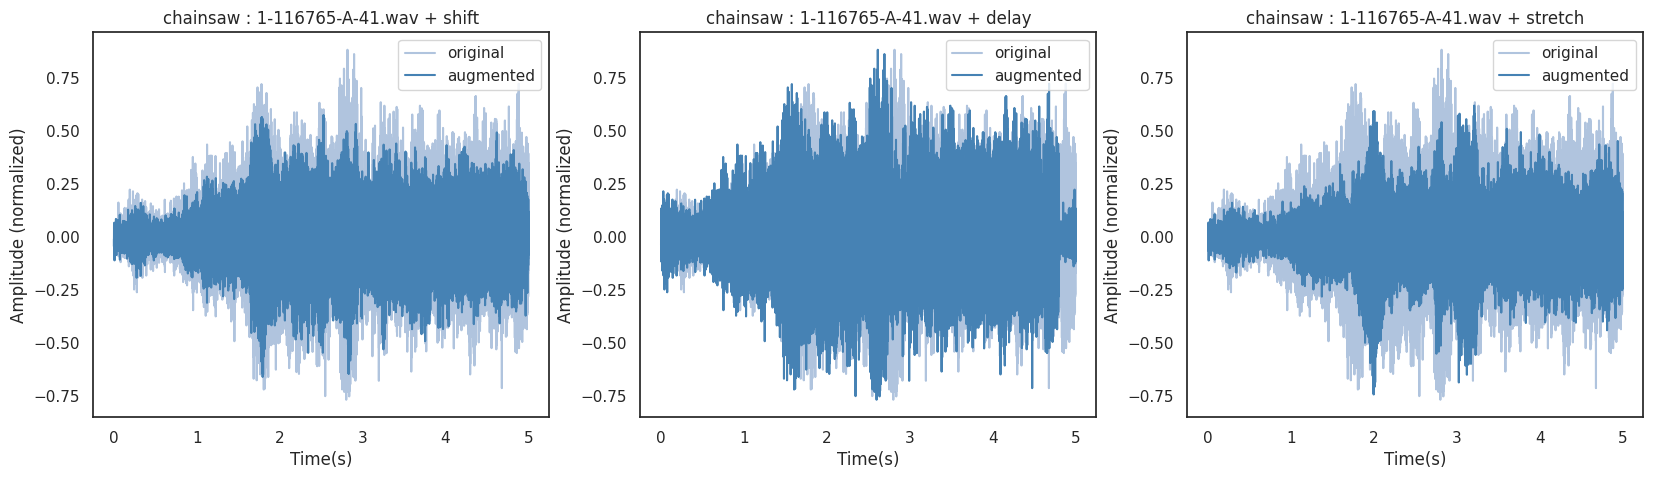

In [ ]:
clip = clips_50[180]
fig_size = (20,5)
colors = ["lightsteelblue", "steelblue"]
plot_augmentations(clip, augmented_clips_dict, fig_size, colors)

## 2.2 Segmentation
To augment the data, each clip is segmented into partially superimposed segments, over which we compute:
- Features for the CNN branch: log-scaled mel spectrograms and their deltas;
- Features for the RNN branch: the first 13 MFCC coefficients.

The segmentation will be done separately (later) for the sequential and multi-branch architectures, inside the *preprocess_pipeline* function. Here we see an example of segmentation for the multibranch architecture.

In [6]:
# Load augmented Clips from pickle file
with open("clips_50_aug.pkl", "rb") as fp:
  clips_50_aug = pickle.load(fp)

In [7]:
# Turn labels into one-hot encoded label arrays
y_50_aug = create_labels_array(clips_50_aug)

# See result for a sample
clip = clips_50_aug[180]
category = clip.category
label = y_50_aug[180]
print('Label of selected clip: {0}\nCorresponding one-hot representation: {1}'.format(category, label))


Label of selected clip: breathing
Corresponding one-hot representation: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]


In [8]:
architecture = 'multibranch'
mode = 'train'
cnn_seg, rnn_seg, train_labels, train_folds, train_clip_id = segmentation(clips_50_aug, y_50_aug, architecture, mode)

print('Samples before segmentation: {0}\nSamples after segmanetation: {1}\nShape of CNN input:{2}\nShape of RNN input :{3}'.format(len(clips_50_aug), train_labels.shape[0], cnn_seg.shape, rnn_seg.shape))

Samples before segmentation: 7500
Samples after segmanetation: 22500
Shape of CNN input:(22500, 60, 101, 2)
Shape of RNN input :(22500, 101, 13)


In [10]:
del(clips_50_aug)
gc.collect()

69

## 2.3 Fold subdivision

In [11]:
X_cnn_folds, Y_folds, train_clip_id_folds = divide_folds(cnn_seg, train_labels, train_clip_id, train_folds)
X_rnn_folds, _, _ = divide_folds(rnn_seg, train_labels, train_clip_id, train_folds)

print('Shape of CNN input after 5-fold subdivision:{0}\nShape of RNN input after 5-fold subdivision:{1}'.format(X_cnn_folds.shape, X_rnn_folds.shape))

Shape of CNN input after 5-fold subdivision:(5, 4500, 60, 101, 2)
Shape of RNN input after 5-fold subdivision:(5, 4500, 101, 13)


In [12]:
del(cnn_seg, rnn_seg, train_labels, train_folds, train_clip_id)
gc.collect()

60

# 3. **Preliminary architecture experiments**
In the first stages of implementation, a simpler architecture was developed to be compared with the proposed multi-branch architecture, and explore the trade-off between simplicity of architecture and performance.    
In this architecture, the RNN layer is applied directly after the 2D CNN, further processing the same input features.    
This section shows the implementation of both architectures and their comparison on a training with the following parameters:
- $50$ epochs;
- $2000$ Dense units in the Fully connected layers;
- $32$ or $64$ GRU units in the RNN.    
    
The functions used for training and saving metrics are implemented in the *train_test_model.py* module.    
Note that for this training phase, we don't need `clips_id` (id identifying from which clip the segment was extracted) or `y_clips` (labels per-clip instead of per-segment); they will be used later when computing different metrics in the model selection phase.

## 3.1 Sequential C-RNN

#### **Loading and preprocessing routine**

In [8]:
mode = 'train'
architecture = 'sequential'
name_file = 'clips_50_aug.pkl'
X_folds, Y_folds, folds, _, _ = preprocess_pipeline(mode, architecture, name_file)
print('{0} Training samples.\nShapes of input tensor: {1}'.format(len(folds), X_folds.shape))

22500 Training samples.
Shapes of input tensor: (5, 4500, 60, 101, 2)


#### **Preparing dataset for CNN**

In [ ]:
# The first 4 folds are concatenated to use as training dataset
X_train = np.concatenate((X_folds[0],X_folds[1],X_folds[2],X_folds[3]), axis = 0)
Y_train = np.concatenate((Y_folds[0],Y_folds[1],Y_folds[2],Y_folds[3]), axis = 0)

# Shuffle indices before creating tf.Dataset, to keep the correspondence between X and Y
indices = np.arange(len(X_train))
np.random.shuffle(indices)
# Apply shuffled indices to all arrays
X_train = X_train[indices]
Y_train = Y_train[indices]

# Select validation fold
X_val = X_folds[4]
Y_val = Y_folds[4]

# Free memory
del(X_folds, Y_folds)
gc.collect()

4

In [ ]:
# Batch the datasets
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, Y_val)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [ ]:
del(X_train,Y_train, X_val, Y_val)
gc.collect()

0

#### **Architecture**

In [ ]:
def cnn2d(X_input):

  X = tf.keras.layers.Conv2D(80, (57, 6), padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01), name='2D_Conv_1')(X_input)
  X = tf.keras.layers.BatchNormalization()(X)
  X = tf.keras.layers.ReLU()(X)
  X = tf.keras.layers.MaxPool2D((4, 3), strides=(1, 3), padding='same')(X)
  X = tf.keras.layers.Dropout(0.5)(X)

  X = tf.keras.layers.Conv2D(80, (1, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01), name='2D_Conv_2')(X)
  X = tf.keras.layers.BatchNormalization()(X)
  X = tf.keras.layers.ReLU()(X)
  X = tf.keras.layers.MaxPool2D((1, 3), strides=(1, 3), padding='same')(X)
  X = tf.keras.layers.Dropout(0.5)(X)

  return X

In [ ]:
def rnn(X_input, n_units):
  X = tf.keras.layers.GRU(n_units, return_sequences=False, name='GRU')(X_input)
  return X

In [ ]:
def cnn2d_rnn_sequential(input_shape_cnn2d, n_units):

    ### 2D CNN ###
    X_input_1 = tf.keras.Input(shape=input_shape_cnn2d, name='Input_cnn_2D')
    X_1 = cnn2d(X_input_1)

    # Reshape for RNN
    shape = tf.keras.backend.int_shape(X_1)  # (batch_size, new_H, new_W, channels)
    X_1_reshaped = tf.keras.layers.Reshape((-1, shape[1] * shape[3]))(X_1)  # (Batch, Time steps=W, Features=H*C)

    ### RNN ###
    X_2 = rnn(X_1_reshaped, n_units)  # RNN processing


    ### FULLY CONNECTED LAYERS ###
    X = tf.keras.layers.Dense(2000, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01), name="Dense_1")(X_2)
    X = tf.keras.layers.Dropout(0.5)(X)
    X = tf.keras.layers.Dense(2000, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01), name="Dense_2")(X)
    X = tf.keras.layers.Dropout(0.5)(X)
    output = tf.keras.layers.Dense(50, activation="softmax", name="Output")(X)  # Output Layer

    ### CREATE MODEL ###
    model = tf.keras.models.Model(inputs=X_input_1, outputs=output)

    return model


### 3.1.1 **TRAINING**

#### $\bullet$ 32 GRU units

In [ ]:
segment_length = 101
input_shape= (60, segment_length, 2)

num_epochs = 50
n_units = 32
save_model = False

In [ ]:
train_sequential(cnn2d_rnn_sequential, input_shape, train_dataset, val_dataset, num_epochs, n_units, save_model)

Training model with 32 GRU units.  Trainable parameters: 4706514
Epoch 1/50
563/563 ━━━━━━━━━━━━━━━━━━━━ 49s 71ms/step - accuracy: 0.0298 - loss: 21.5176 - val_accuracy: 0.0631 - val_loss: 12.3506 - learning_rate: 0.0040
Epoch 2/50
563/563 ━━━━━━━━━━━━━━━━━━━━ 76s 67ms/step - accuracy: 0.0887 - loss: 10.5735 - val_accuracy: 0.1133 - val_loss: 6.9417 - learning_rate: 0.0040
Epoch 3/50
563/563 ━━━━━━━━━━━━━━━━━━━━ 37s 66ms/step - accuracy: 0.1602 - loss: 6.0614 - val_accuracy: 0.1713 - val_loss: 4.6903 - learning_rate: 0.0040
Epoch 4/50
563/563 ━━━━━━━━━━━━━━━━━━━━ 41s 66ms/step - accuracy: 0.2182 - loss: 4.1511 - val_accuracy: 0.2311 - val_loss: 3.7180 - learning_rate: 0.0040
Epoch 5/50
563/563 ━━━━━━━━━━━━━━━━━━━━ 37s 66ms/step - accuracy: 0.2665 - loss: 3.3195 - val_accuracy: 0.2407 - val_loss: 3.3473 - learning_rate: 0.0040
Epoch 6/50
563/563 ━━━━━━━━━━━━━━━━━━━━ 37s 66ms/step - accuracy: 0.2949 - loss: 2.9453 - val_accuracy: 0.2344 - val_loss: 3.1995 - learning_rate: 0.0040
Epoch 7/

#### $\bullet$ 64 GRU units

In [ ]:
segment_length = 101
input_shape= (60, segment_length, 2)

num_epochs = 50
n_units = 64
save_model = False

In [ ]:
train_sequential(cnn2d_rnn_sequential, input_shape, train_dataset, val_dataset, num_epochs, n_units, save_model)

Training model with 64 GRU units.  Trainable parameters: 5240722
Epoch 1/50
563/563 ━━━━━━━━━━━━━━━━━━━━ 44s 71ms/step - accuracy: 0.0309 - loss: 22.0013 - val_accuracy: 0.0760 - val_loss: 12.5402 - learning_rate: 0.0040
Epoch 2/50
563/563 ━━━━━━━━━━━━━━━━━━━━ 38s 67ms/step - accuracy: 0.1195 - loss: 10.6451 - val_accuracy: 0.1509 - val_loss: 6.9163 - learning_rate: 0.0040
Epoch 3/50
563/563 ━━━━━━━━━━━━━━━━━━━━ 37s 66ms/step - accuracy: 0.2117 - loss: 5.9392 - val_accuracy: 0.2120 - val_loss: 4.5476 - learning_rate: 0.0040
Epoch 4/50
563/563 ━━━━━━━━━━━━━━━━━━━━ 41s 67ms/step - accuracy: 0.2810 - loss: 3.9550 - val_accuracy: 0.2724 - val_loss: 3.5945 - learning_rate: 0.0040
Epoch 5/50
563/563 ━━━━━━━━━━━━━━━━━━━━ 37s 66ms/step - accuracy: 0.3374 - loss: 3.0611 - val_accuracy: 0.2784 - val_loss: 3.3120 - learning_rate: 0.0040
Epoch 6/50
563/563 ━━━━━━━━━━━━━━━━━━━━ 37s 66ms/step - accuracy: 0.3839 - loss: 2.6638 - val_accuracy: 0.2771 - val_loss: 3.1859 - learning_rate: 0.0040
Epoch 7/

## 3.2 **Multi-branch C-RNN**

#### **Loading and preprocessing routine**

In [10]:
mode = 'train'
architecture = 'multibranch'
name_file = 'clips_50_aug.pkl'
X_cnn_folds, X_rnn_folds, Y_folds, folds, _, _ = preprocess_pipeline(mode, architecture, name_file)
print('{0} Training samples.\nShape of CNN input tensor: {1}\nShape of RNN input tensor: {2}'.format(len(folds),  X_cnn_folds.shape, X_rnn_folds.shape))

22500 Training samples.
Shape of CNN input tensor: (5, 4500, 60, 101, 2)
Shape of RNN input tensor: (5, 4500, 101, 13)


#### **Preparing dataset for CRNN**

In [ ]:
# The first 4 folds are concatenated to use as training dataset
X_cnn_train = np.concatenate((X_cnn_folds[0],X_cnn_folds[1],X_cnn_folds[2],X_cnn_folds[3]), axis = 0)
X_rnn_train = np.concatenate((X_rnn_folds[0],X_rnn_folds[1],X_rnn_folds[2],X_rnn_folds[3]), axis = 0)

Y_train = np.concatenate((Y_folds[0],Y_folds[1],Y_folds[2],Y_folds[3]), axis = 0)

# Shuffle indices before creating tf.Dataset, to keep the correspondence between X and Y
indices = np.arange(len(X_cnn_train))
np.random.shuffle(indices)
# Apply shuffled indices to all arrays
X_cnn_train = X_cnn_train[indices]
X_rnn_train = X_rnn_train[indices]
Y_train = Y_train[indices]

# Select validation fold
X_cnn_val = X_cnn_folds[4]
X_rnn_val = X_rnn_folds[4]
Y_val = Y_folds[4]

del(X_cnn_folds, X_rnn_folds,Y_folds)
gc.collect()

4

In [ ]:
# Batch the datasets
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices(((X_cnn_train, X_rnn_train), Y_train)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices(((X_cnn_val, X_rnn_val), Y_val)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [ ]:
del(X_cnn_train,X_rnn_train,Y_train, X_cnn_val, X_rnn_val, Y_val)
gc.collect()

0

#### **Architecture**

In [ ]:
def cnn2d(X_input):

  X = tf.keras.layers.Conv2D(80, (57, 6), padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01), name='2D_Conv_1')(X_input)
  X = tf.keras.layers.BatchNormalization()(X)
  X = tf.keras.layers.ReLU()(X)
  X = tf.keras.layers.MaxPool2D((4, 3), strides=(1, 3), padding='same')(X)
  X = tf.keras.layers.Dropout(0.5)(X)

  X = tf.keras.layers.Conv2D(80, (1, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01), name='2D_Conv_2')(X)
  X = tf.keras.layers.BatchNormalization()(X)
  X = tf.keras.layers.ReLU()(X)
  X = tf.keras.layers.MaxPool2D((1, 3), strides=(1, 3), padding='same')(X)
  X = tf.keras.layers.Dropout(0.5)(X)

  return X

In [ ]:
def rnn(X_input, n_units, bidirectional):

  if bidirectional == True:
    X = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(n_units, return_sequences=False, name='BiGRU'))(X_input)
  else:
    X = tf.keras.layers.GRU(n_units, return_sequences=False, name='GRU')(X_input)
  return X

In [ ]:
def cnn2d_rnn_multibranch(input_shape_cnn, input_shape_rnn, n_units, bidirectional, dense_neurons):

    ### BRANCH 1: 2D CNN ###
    X_input_1 = tf.keras.Input(shape=input_shape_cnn, name='Input_cnn_2D')
    X_1 = cnn2d(X_input_1)
    X_1 = tf.keras.layers.Flatten()(X_1)  # Flatten before fusion


    ### BRANCH 2:  RNN ###
    X_input_2 = tf.keras.Input(shape=input_shape_rnn, name='Input_rnn')
    X_2 = rnn(X_input_2, n_units, bidirectional)
    X_2 = tf.keras.layers.Flatten()(X_2)

    ### CONCATENATION ###
    X = tf.keras.layers.Concatenate()([X_1, X_2])

    ### FULLY CONNECTED LAYERS ###
    X = tf.keras.layers.Dense(dense_neurons, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01), name="Dense_1")(X)
    X = tf.keras.layers.Dropout(0.5)(X)
    X = tf.keras.layers.Dense(dense_neurons, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01), name="Dense_2")(X)
    X = tf.keras.layers.Dropout(0.5)(X)
    output = tf.keras.layers.Dense(50, activation="softmax", name="Output")(X)  # Output Layer

    ### CREATE MODEL ###
    model = tf.keras.models.Model(inputs=[X_input_1, X_input_2], outputs=output)

    return model


In [ ]:
# Just to see complexity of the model
segment_length = 101
input_shape_cnn = (60, segment_length, 2)
input_shape_rnn = (segment_length, 13)
num_epochs = 50
n_units = 32
dense_neurons = 2000

optimizer = tf.keras.optimizers.SGD(learning_rate=0.004, momentum=0.9, nesterov=True)
model = cnn2d_rnn_multibranch(input_shape_cnn, input_shape_rnn, n_units, bidirectional, dense_neurons)
model.compile(optimizer=optimizer, loss="categorical_crossentropy",  metrics=["accuracy"])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Input_cnn_2D (InputLayer) │ (None, 60, 101, 2)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ 2D_Conv_1 (Conv2D)        │ (None, 60, 101, 80)    │         54,800 │ Input_cnn_2D[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 60, 101, 80)    │            320 │ 2D_Conv_1[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 60, 101, 80)    │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 60, 34, 80)     │              0 │ re_lu[0][0]            │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 60, 34, 80)     │              0 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ 2D_Conv_2 (Conv2D)        │ (None, 60, 34, 80)     │         19,280 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 60, 34, 80)     │            320 │ 2D_Conv_2[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 60, 34, 80)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 60, 12, 80)     │              0 │ re_lu_1[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Input_rnn (InputLayer)    │ (None, 101, 13)        │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 60, 12, 80)     │              0 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ GRU (GRU)                 │ (None, 32)             │          4,512 │ Input_rnn[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 57600)          │              0 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 32)             │              0 │ GRU[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 57632)          │              0 │ flatten[0][0],         │
│                           │                        │                │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Dense_1 (Dense)           │ (None, 2000)           │    115,266,000 │ concatenate[0][0]      │
├──────────────────────

 Total params: 119,447,282 (455.66 MB)

 Trainable params: 119,446,962 (455.65 MB)

 Non-trainable params: 320 (1.25 KB)

### 3.2.1 **TRAINING**

#### $\bullet$ 32 GRU units, 2000 dense neurons

In [ ]:
segment_length = 101
input_shape_cnn = (60, segment_length, 2)
input_shape_rnn = (segment_length, 13)
num_epochs = 50 #just to test
n_units = 32
bidirectional = False
dense_neurons = 2000
save_model = True

In [ ]:
train_multibranch(cnn2d_rnn_multibranch, input_shape_cnn, input_shape_rnn, train_dataset, val_dataset, num_epochs, n_units, bidirectional, dense_neurons, save_model)

Training model with 32 GRU units, 2000 Dense hidden units, bidirectional = False.  Trainable parameters: 119446962
Epoch 1/50
563/563 ━━━━━━━━━━━━━━━━━━━━ 80s 126ms/step - accuracy: 0.0321 - loss: 54.7402 - val_accuracy: 0.0613 - val_loss: 28.8170 - learning_rate: 0.0040
Epoch 2/50
563/563 ━━━━━━━━━━━━━━━━━━━━ 71s 127ms/step - accuracy: 0.0669 - loss: 24.0912 - val_accuracy: 0.1144 - val_loss: 13.6425 - learning_rate: 0.0040
Epoch 3/50
563/563 ━━━━━━━━━━━━━━━━━━━━ 72s 128ms/step - accuracy: 0.1109 - loss: 11.7573 - val_accuracy: 0.2198 - val_loss: 7.2691 - learning_rate: 0.0040
Epoch 4/50
563/563 ━━━━━━━━━━━━━━━━━━━━ 81s 127ms/step - accuracy: 0.1785 - loss: 6.5912 - val_accuracy: 0.2936 - val_loss: 4.7029 - learning_rate: 0.0040
Epoch 5/50
563/563 ━━━━━━━━━━━━━━━━━━━━ 71s 127ms/step - accuracy: 0.2559 - loss: 4.4225 - val_accuracy: 0.3133 - val_loss: 3.6992 - learning_rate: 0.0040
Epoch 6/50
563/563 ━━━━━━━━━━━━━━━━━━━━ 71s 127ms/step - accuracy: 0.3384 - loss: 3.4628 - val_accuracy: 

Training time: 3719.2194681167603


#### $\bullet$ 64 GRU units, 2000 dense neurons

In [ ]:
segment_length = 101
input_shape_cnn = (60, segment_length, 2)
input_shape_rnn = (segment_length, 13)
num_epochs = 50 #just to test
n_units = 64
bidirectional = False
dense_neurons = 2000
save_model = True

In [ ]:
train_multibranch(cnn2d_rnn_multibranch, input_shape_cnn, input_shape_rnn, train_dataset, val_dataset, num_epochs, n_units, bidirectional, dense_neurons, save_model)

Training model with 64 GRU units.  Trainable parameters: 119521618
Epoch 1/50
563/563 ━━━━━━━━━━━━━━━━━━━━ 80s 125ms/step - accuracy: 0.0313 - loss: 54.7139 - val_accuracy: 0.0796 - val_loss: 28.6515 - learning_rate: 0.0040
Epoch 2/50
563/563 ━━━━━━━━━━━━━━━━━━━━ 71s 126ms/step - accuracy: 0.0545 - loss: 24.0380 - val_accuracy: 0.1318 - val_loss: 13.5626 - learning_rate: 0.0040
Epoch 3/50
563/563 ━━━━━━━━━━━━━━━━━━━━ 71s 127ms/step - accuracy: 0.1050 - loss: 11.7370 - val_accuracy: 0.1760 - val_loss: 7.3493 - learning_rate: 0.0040
Epoch 4/50
563/563 ━━━━━━━━━━━━━━━━━━━━ 72s 128ms/step - accuracy: 0.1404 - loss: 6.6984 - val_accuracy: 0.2233 - val_loss: 4.8287 - learning_rate: 0.0040
Epoch 5/50
563/563 ━━━━━━━━━━━━━━━━━━━━ 72s 128ms/step - accuracy: 0.1835 - loss: 4.5728 - val_accuracy: 0.3069 - val_loss: 3.7286 - learning_rate: 0.0040
Epoch 6/50
563/563 ━━━━━━━━━━━━━━━━━━━━ 82s 128ms/step - accuracy: 0.2283 - loss: 3.6523 - val_accuracy: 0.3324 - val_loss: 3.2930 - learning_rate: 0.004

# 4. **Tuning parameters**
In this section, after observing the results from the preliminary experiments, further exploration of the Multi-branch architecture is performed in order to improve its performance while also reducing its computational complexity.    
In order to do so, I have posed my attention to:
- The number of dense units in the Fully Connected layers: since they are responsible, for the most part, for the large number of parameters of the model, I tested the architecture with a reduced number of hidden units (from $2000$ to $1000$);
- The bi-directionality of the GRU layer: to better understand the role of the RNN branch, I also wanted to tune the architecture of that specific branch; I avoided adding more layers due to computational time and limited resources, but I tested whether a bi-directional GRU layer could improve performance.

#### $\bullet$ **32 GRU UNITS, 1000 DENSE NEURONS, NON BI-DIRECTIONAL GRU**

In [ ]:
segment_length = 101
input_shape_cnn = (60, segment_length, 2)
input_shape_rnn = (segment_length, 13)
num_epochs = 50 #just to test
n_units = 32
bidirectional = False
dense_neurons = 1000
save_model = True

In [ ]:
train_multibranch(cnn2d_rnn_multibranch, input_shape_cnn, input_shape_rnn, train_dataset, val_dataset, num_epochs, n_units, bidirectional, dense_neurons, save_model)

Training model with 32 GRU units, 1000 Dense hidden units, bidirectional = False.  Trainable parameters: 58762962
Epoch 1/50
563/563 ━━━━━━━━━━━━━━━━━━━━ 62s 96ms/step - accuracy: 0.0222 - loss: 30.2659 - val_accuracy: 0.0404 - val_loss: 16.7873 - learning_rate: 0.0040
Epoch 2/50
563/563 ━━━━━━━━━━━━━━━━━━━━ 54s 96ms/step - accuracy: 0.0335 - loss: 14.3641 - val_accuracy: 0.0704 - val_loss: 9.0179 - learning_rate: 0.0040
Epoch 3/50
563/563 ━━━━━━━━━━━━━━━━━━━━ 54s 96ms/step - accuracy: 0.0564 - loss: 8.0143 - val_accuracy: 0.0962 - val_loss: 5.6402 - learning_rate: 0.0040
Epoch 4/50
563/563 ━━━━━━━━━━━━━━━━━━━━ 82s 95ms/step - accuracy: 0.0900 - loss: 5.2926 - val_accuracy: 0.1504 - val_loss: 4.2122 - learning_rate: 0.0040
Epoch 5/50
563/563 ━━━━━━━━━━━━━━━━━━━━ 53s 94ms/step - accuracy: 0.1163 - loss: 4.1419 - val_accuracy: 0.1684 - val_loss: 3.6373 - learning_rate: 0.0040
Epoch 6/50
563/563 ━━━━━━━━━━━━━━━━━━━━ 53s 95ms/step - accuracy: 0.1539 - loss: 3.5996 - val_accuracy: 0.2344 - 

Training time: 2911.8213243484497


#### $\bullet$ **32 GRU UNITS, 1000 DENSE NEURONS, BIDIRECTIONAL GRU**

In [ ]:
segment_length = 101
input_shape_cnn = (60, segment_length, 2)
input_shape_rnn = (segment_length, 13)
num_epochs = 50 #just to test
n_units = 32
bidirectional = True
dense_neurons = 1000
save_model = True

In [ ]:
train_multibranch(cnn2d_rnn_multibranch, input_shape_cnn, input_shape_rnn, train_dataset, val_dataset, num_epochs, n_units, bidirectional, dense_neurons, save_model)

Training model with 32 GRU units, 1000 Dense hidden units, bidirectional = True.  Trainable parameters: 58799474
Epoch 1/50
563/563 ━━━━━━━━━━━━━━━━━━━━ 63s 96ms/step - accuracy: 0.0279 - loss: 30.1862 - val_accuracy: 0.0367 - val_loss: 16.7583 - learning_rate: 0.0040
Epoch 2/50
563/563 ━━━━━━━━━━━━━━━━━━━━ 54s 96ms/step - accuracy: 0.0374 - loss: 14.3516 - val_accuracy: 0.0747 - val_loss: 9.0492 - learning_rate: 0.0040
Epoch 3/50
563/563 ━━━━━━━━━━━━━━━━━━━━ 55s 99ms/step - accuracy: 0.0509 - loss: 8.0321 - val_accuracy: 0.1069 - val_loss: 5.7410 - learning_rate: 0.0040
Epoch 4/50
563/563 ━━━━━━━━━━━━━━━━━━━━ 81s 97ms/step - accuracy: 0.0898 - loss: 5.3364 - val_accuracy: 0.1460 - val_loss: 4.3330 - learning_rate: 0.0040
Epoch 5/50
563/563 ━━━━━━━━━━━━━━━━━━━━ 54s 96ms/step - accuracy: 0.1111 - loss: 4.1837 - val_accuracy: 0.2020 - val_loss: 3.6397 - learning_rate: 0.0040
Epoch 6/50
563/563 ━━━━━━━━━━━━━━━━━━━━ 54s 96ms/step - accuracy: 0.1317 - loss: 3.6483 - val_accuracy: 0.1909 - v

Training time: 2982.2726209163666


# 5. **Model selection**
In the final stage of the project, since the validation accuracy from the training phase was not conclusive enough, I decided to compute different metrics in the validation set, while also testing different architectures for model selection.    

Specifically, I focused on how the number of hidden units in the Dense layers ($2000$ or $1000$) and the bi-directionaluty of the GRU layer influenced the performance on the classification task.   
From bnow I refer to:
- **Variant A** : multibranch CRNN with $2000$ neurons per dense layer, GRU not bi-directional;
- **Variant B** : multibranch CRNN with $1000$ neurons per dense layer, GRU not bi-directional;
- **Variant C** : multibranch CRNN with $1000$ neurons per dense layer, GRU bi-directional.    


For the comparison, I evaluated:
- **Accuracy**
- **Precision**
- **Recall**
- **F1 score**    

Finally, I examined the per-class accuracy and visualized it to better understand where the architecture struggles most.    
All the testing functions are implemented in the *train_test_model.py* model.

### **Loading routine**

In [6]:
mode = 'train'
architecture = 'multibranch'
name_file = 'clips_50_aug.pkl'
X_cnn, X_rnn, Y, folds, clip_id_folds, y_clips = preprocess_pipeline(mode, architecture, name_file)


#Then, only select the last fold(validation)
val_clip_id = clip_id_folds[4]
X_cnn_val = X_cnn[4]
X_rnn_val = X_rnn[4]
Y_val = Y[4]

del(X_cnn, X_rnn, Y, clip_id_folds, folds)
gc.collect()

4

**NOTE**: Since `y_clips` is the label array PER FULL CLIP, while `clip_id_folds` is the full clip ID associated to EACH SEGMENT (identifying the clip from which the segment is extracted from), to get the clip label associated to each segment we simply have to match ids with `y_clips`'s indexes.    
Since there are 3 segments per clip, and they are in order in the clip_id_array, in order to make sure to maintain the order (which could not be guaranteed by using np.unique) We can simply select every third value, and assign the corresponding label.



In [7]:
n_val_clips = int(len(val_clip_id)/3)
val_clip_labels = np.zeros((n_val_clips, 50))
for i in range(n_val_clips):
  index = int(val_clip_id[3*i])
  val_clip_labels[i,:] = y_clips[index,:]

In [8]:
print('Clips for model selection: {0},  validation samples after segmentation: {1}\nCNN input shape: {2}\nRNN input shape: {3}\n'.format(n_val_clips, len(val_clip_id), X_cnn_val.shape, X_rnn_val.shape))

Clips for model selection: 1500,  validation samples after segmentation: 4500
CNN input shape: (4500, 60, 101, 2)
RNN input shape: (4500, 101, 13)



In [9]:
# From val_clip_labels (the one-hot encoded labels associated to each of the original clips), extract an array with the number of the corresponding class
Y_true = np.argmax(val_clip_labels, axis=1)

# Prepare test dataset for testing
batch_size = 32
val_dataset = tf.data.Dataset.from_tensor_slices(((X_cnn_val, X_rnn_val), Y_val)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

## **5.1 Computing metrics**

### 5.1.1 Variant A

In [10]:
model_a = tf.keras.models.load_model("cnn2d_rnn_multibranch_32_2000_F.h5")
predictions = model_a.predict(val_dataset)

141/141 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step


In [ ]:
model_a.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Input_cnn_2D (InputLayer) │ (None, 60, 101, 2)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ 2D_Conv_1 (Conv2D)        │ (None, 60, 101, 80)    │         54,800 │ Input_cnn_2D[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 60, 101, 80)    │            320 │ 2D_Conv_1[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 60, 101, 80)    │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 60, 34, 80)     │              0 │ re_lu[0][0]            │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 60, 34, 80)     │              0 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ 2D_Conv_2 (Conv2D)        │ (None, 60, 34, 80)     │         19,280 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 60, 34, 80)     │            320 │ 2D_Conv_2[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 60, 34, 80)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 60, 12, 80)     │              0 │ re_lu_1[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Input_rnn (InputLayer)    │ (None, 101, 13)        │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 60, 12, 80)     │              0 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ GRU (GRU)                 │ (None, 32)             │          4,512 │ Input_rnn[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 57600)          │              0 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 32)             │              0 │ GRU[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 57632)          │              0 │ flatten[0][0],         │
│                           │                        │                │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Dense_1 (Dense)           │ (None, 2000)           │    115,266,000 │ concatenate[0][0]      │
├──────────────────────

 Total params: 119,447,284 (455.66 MB)

 Trainable params: 119,446,962 (455.65 MB)

 Non-trainable params: 320 (1.25 KB)

 Optimizer params: 2 (12.00 B)

In [11]:
# Compute predicted labels for a single clip by averaging segments predictions
Y_pred_a = aggregate_predictions(predictions, val_clip_id)

In [12]:
# Compute all metrics
final_accuracy_a = accuracy_score(Y_true, Y_pred_a)
class_accuracy_a = accuracy_per_class(Y_true, Y_pred_a)
precision_a, recall_a, f1_a, _ = precision_recall_fscore_support(Y_true, Y_pred_a, average='macro')

# Load stored complexity metrics into dictionary
complexity_a = {}
with open('cnn2d_rnn_multibranch_32_2000_F_metrics.npz_complexity.txt', 'r') as f:
    for line in f:
        key, value = line.strip().split(": ")
        complexity_a[key] = float(value) if "." in value else int(value)

### 5.2. Variant B

In [13]:
model_b = tf.keras.models.load_model("cnn2d_rnn_multibranch_32_1000_F.h5")
predictions = model_b.predict(val_dataset)

141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step


In [ ]:
model_b.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Input_cnn_2D (InputLayer) │ (None, 60, 101, 2)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ 2D_Conv_1 (Conv2D)        │ (None, 60, 101, 80)    │         54,800 │ Input_cnn_2D[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 60, 101, 80)    │            320 │ 2D_Conv_1[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 60, 101, 80)    │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 60, 34, 80)     │              0 │ re_lu[0][0]            │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 60, 34, 80)     │              0 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ 2D_Conv_2 (Conv2D)        │ (None, 60, 34, 80)     │         19,280 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 60, 34, 80)     │            320 │ 2D_Conv_2[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 60, 34, 80)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 60, 12, 80)     │              0 │ re_lu_1[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Input_rnn (InputLayer)    │ (None, 101, 13)        │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 60, 12, 80)     │              0 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ GRU (GRU)                 │ (None, 32)             │          4,512 │ Input_rnn[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 57600)          │              0 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 32)             │              0 │ GRU[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 57632)          │              0 │ flatten[0][0],         │
│                           │                        │                │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Dense_1 (Dense)           │ (None, 1000)           │     57,633,000 │ concatenate[0][0]      │
├──────────────────────

 Total params: 58,763,284 (224.16 MB)

 Trainable params: 58,762,962 (224.16 MB)

 Non-trainable params: 320 (1.25 KB)

 Optimizer params: 2 (12.00 B)

In [14]:
# Compute predictions per clip by aggregation of segments predictions
Y_pred_b = aggregate_predictions(predictions, val_clip_id)

In [15]:
final_accuracy_b = accuracy_score(Y_true, Y_pred_b)
class_accuracy_b = accuracy_per_class(Y_true, Y_pred_b)
precision_b, recall_b, f1_b, _ = precision_recall_fscore_support(Y_true, Y_pred_b, average='macro')

# Load stored complexity metrics into dictionary
complexity_b = {}
with open('cnn2d_rnn_multibranch_32_1000_F_metrics.npz_complexity.txt', 'r') as f:
    for line in f:
        key, value = line.strip().split(": ")
        complexity_b[key] = float(value) if "." in value else int(value)

### 5.3 Variant C

In [16]:
model_c = tf.keras.models.load_model("cnn2d_rnn_multibranch_32_1000_T.h5")
predictions = model_c.predict(val_dataset)

141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step


In [ ]:
model_c.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Input_cnn_2D (InputLayer) │ (None, 60, 101, 2)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ 2D_Conv_1 (Conv2D)        │ (None, 60, 101, 80)    │         54,800 │ Input_cnn_2D[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 60, 101, 80)    │            320 │ 2D_Conv_1[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 60, 101, 80)    │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 60, 34, 80)     │              0 │ re_lu[0][0]            │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 60, 34, 80)     │              0 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ 2D_Conv_2 (Conv2D)        │ (None, 60, 34, 80)     │         19,280 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 60, 34, 80)     │            320 │ 2D_Conv_2[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 60, 34, 80)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 60, 12, 80)     │              0 │ re_lu_1[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Input_rnn (InputLayer)    │ (None, 101, 13)        │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 60, 12, 80)     │              0 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 64)             │          9,024 │ Input_rnn[0][0]        │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 57600)          │              0 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 64)             │              0 │ bidirectional[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 57664)          │              0 │ flatten[0][0],         │
│                           │                        │                │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Dense_1 (Dense)      

 Total params: 58,799,796 (224.30 MB)

 Trainable params: 58,799,474 (224.30 MB)

 Non-trainable params: 320 (1.25 KB)

 Optimizer params: 2 (12.00 B)

In [17]:
# Compute predicted labels for a single clip by averaging segments predictions
Y_pred_c = aggregate_predictions(predictions, val_clip_id)

In [18]:
final_accuracy_c = accuracy_score(Y_true, Y_pred_c)
class_accuracy_c = accuracy_per_class(Y_true, Y_pred_c)
precision_c, recall_c, f1_c, _ = precision_recall_fscore_support(Y_true, Y_pred_c, average='macro')

# Load stored complexity metrics into dictionary
complexity_c = {}
with open('cnn2d_rnn_multibranch_32_1000_T_metrics.npz_complexity.txt', 'r') as f:
    for line in f:
        key, value = line.strip().split(": ")
        complexity_c[key] = float(value) if "." in value else int(value)

## **5.2 Comparing models**

### 5.2.1 Compare different n_dense: Variant A vs. Variant B
The first comparison of performance and complexity is between **Variant A** and **Variant B**; both architectures have non bi-directional GRU, but the first one has $2000$ neurons per dense layer, while the second one has $1000$.

In [19]:
print("CLIP LEVEL ACCURACY:\nVariant A (2000 neurons): {:.4f}\nVariant B (1000 neurons): {:.4f}\n".format(final_accuracy_a, final_accuracy_b))
print("PRECISION:\nVariant A (2000 neurons): {:.4f}\nVariant B (1000 neurons): {:.4f}\n".format(precision_a, precision_b))
print("RECALL:\nVariant A (2000 neurons): {:.4f}\nVariant B (1000 neurons): {:.4f}\n".format(recall_a, recall_b))
print("F1-SCORE:\nVariant A (2000 neurons): {:.4f}\nVariant B (1000 neurons): {:.4f}\n".format(f1_a, f1_b))
print("COMPLEXITY (parameters, train time):\nVariant A (2000 neurons): {:.4f} M, {:.4f} s \nVariant B (1000 neurons): {:.4f} M, {:.4f} s\n".format(complexity_a["Trainable Parameters"]/1e6, complexity_a["Training time"],
                                                                                                                                          complexity_b["Trainable Parameters"]/1e6, complexity_b["Training time"]))

CLIP LEVEL ACCURACY:
Variant A (2000 neurons): 0.6613
Variant B (1000 neurons): 0.6500

PRECISION:
Variant A (2000 neurons): 0.6816
Variant B (1000 neurons): 0.6522

RECALL:
Variant A (2000 neurons): 0.6613
Variant B (1000 neurons): 0.6500

F1-SCORE:
Variant A (2000 neurons): 0.6518
Variant B (1000 neurons): 0.6319

COMPLEXITY (parameters, train time):
Variant A (2000 neurons): 119.4470 M, 3719.2195 s 
Variant B (1000 neurons): 58.7630 M, 2911.8213 s



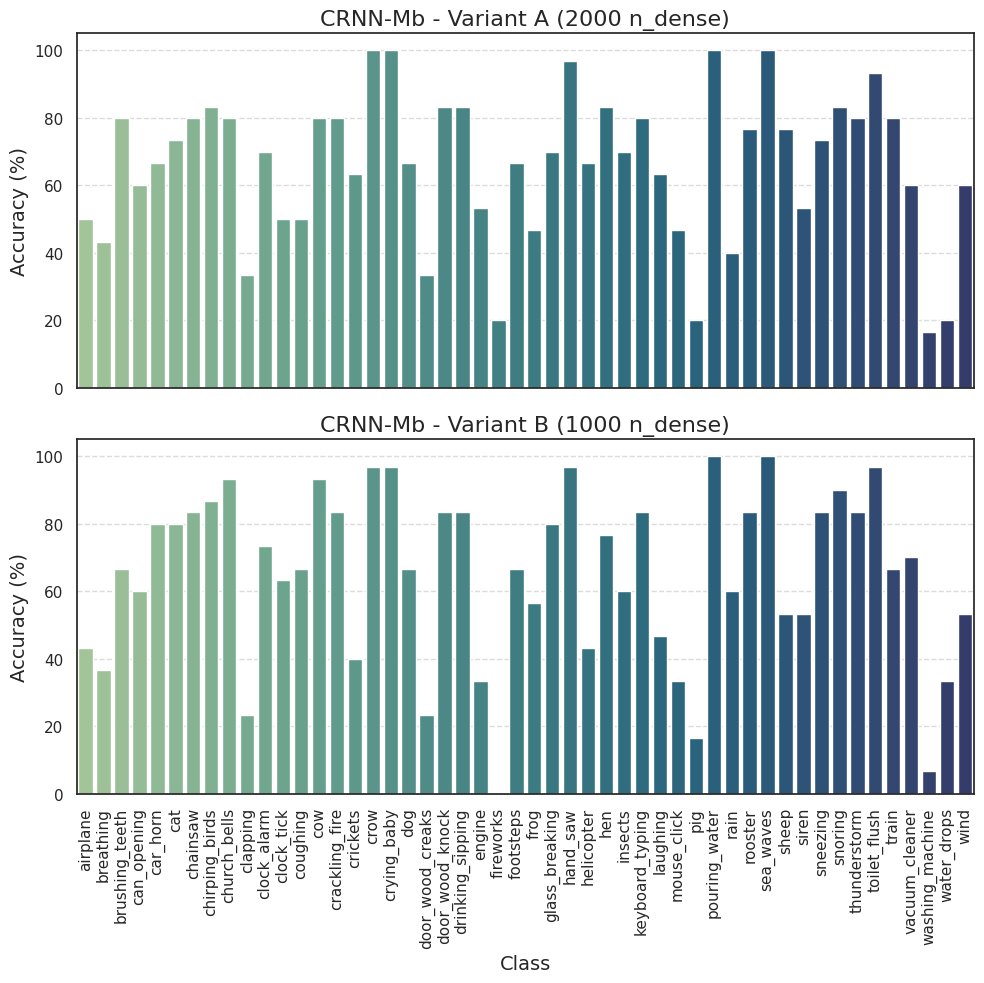

In [20]:
# Here we can see more in detail how the model fare with predictions on specific classes, by computing and visualizing accuracy per class.
model_names = ["CRNN-Mb - Variant A (2000 n_dense)", "CRNN-Mb - Variant B (1000 n_dense)"]
class_accuracy = [class_accuracy_a, class_accuracy_b]
fig_size = (10,5)
sb_palette = "crest"


plot_class_accuracy_2(model_names, class_accuracy, fig_size, sb_palette)

### 5.2.2 Comparing non bi-directional VS bi-directional GRU: Variant B vs. Variant C
In this second part, we can see the effect of having a bi-directional GRU (**Variant C**) vs. having a non-bidirectional GRU (**Variant B**).

In [21]:
print("CLIP LEVEL ACCURACY:\nVariant B (unidirectional GRU): {:.4f}\nVariant C (bi-directional GRU): {:.4f}\n".format(final_accuracy_b, final_accuracy_c))
print("PRECISION:\nVariant B (unidirectional GRU): {:.4f}\nVariant C (bi-directional GRU): {:.4f}\n".format(precision_b, precision_c))
print("RECALL:\nVariant B (unidirectional GRU): {:.4f}\nVariant C (bi-directional GRU): {:.4f}\n".format(recall_b, recall_c))
print("F1-SCORE:\nVariant B (unidirectional GRU): {:.4f}\nVariant C (bi-directional GRU): {:.4f}\n".format(f1_b, f1_c))
print("COMPLEXITY (parameters, train time):\nVariant B (unidirectional GRU): {:.4f} M, {:.4f} s \nVariant C (bi-directional GRU): {:.4f} M, {:.4f} s\n".format(complexity_b["Trainable Parameters"]/1e6, complexity_b["Training time"],
                                                                                                                                          complexity_c["Trainable Parameters"]/1e6, complexity_c["Training time"]))

CLIP LEVEL ACCURACY:
Variant B (unidirectional GRU): 0.6500
Variant C (bi-directional GRU): 0.6547

PRECISION:
Variant B (unidirectional GRU): 0.6522
Variant C (bi-directional GRU): 0.6721

RECALL:
Variant B (unidirectional GRU): 0.6500
Variant C (bi-directional GRU): 0.6547

F1-SCORE:
Variant B (unidirectional GRU): 0.6319
Variant C (bi-directional GRU): 0.6429

COMPLEXITY (parameters, train time):
Variant B (unidirectional GRU): 58.7630 M, 2911.8213 s 
Variant C (bi-directional GRU): 58.7995 M, 2982.2726 s



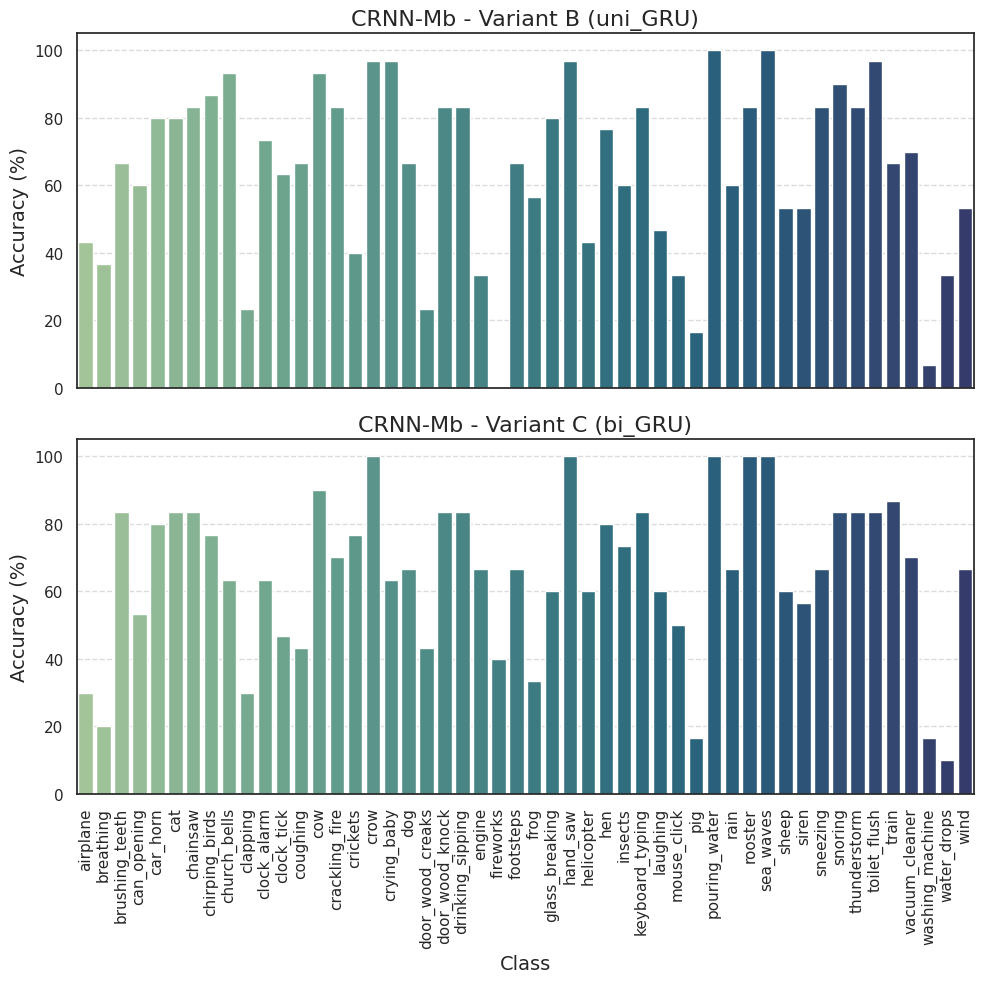

In [22]:
# Here we can see more in detail how the model fare with predictions on specific classes, by computing and visualizing accuracy per class.
model_names = ["CRNN-Mb - Variant B (uni_GRU)", "CRNN-Mb - Variant C (bi_GRU)"]
class_accuracy = [class_accuracy_b, class_accuracy_c]
fig_size = (10,5)
sb_palette = "crest"


plot_class_accuracy_2(model_names, class_accuracy, fig_size, sb_palette)

### 5.2.3 Per-class accuracy: overall comparison

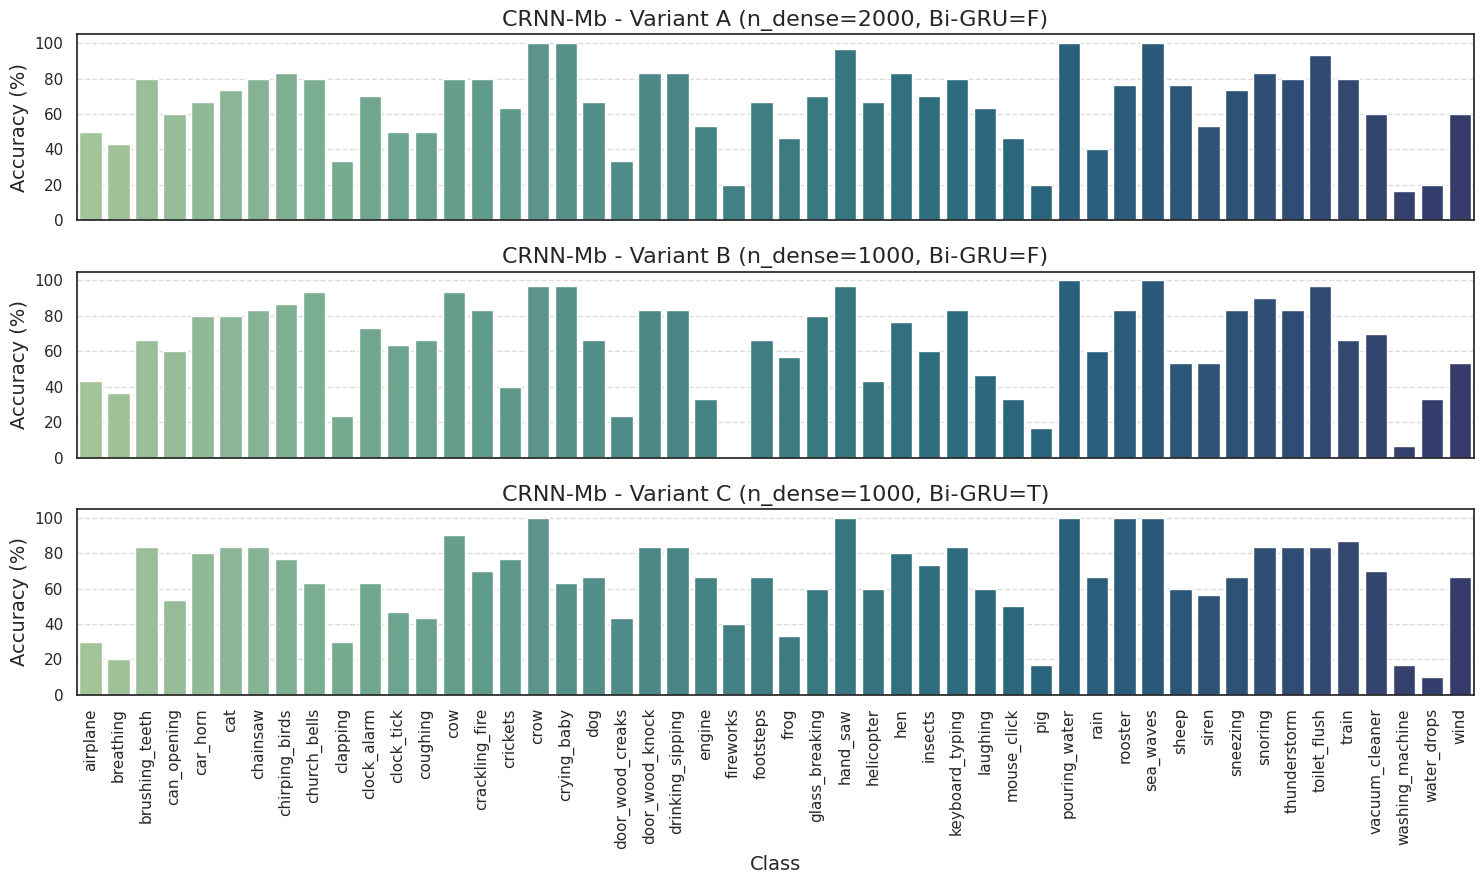

In [23]:
model_names = ["CRNN-Mb - Variant A (n_dense=2000, Bi-GRU=F)", "CRNN-Mb - Variant B (n_dense=1000, Bi-GRU=F)", "CRNN-Mb - Variant C (n_dense=1000, Bi-GRU=T)"]
class_accuracy = [class_accuracy_a, class_accuracy_b, class_accuracy_c]
fig_size = (15,3)
sb_palette = "crest"


plot_class_accuracy_2(model_names, class_accuracy, fig_size, sb_palette)


# 6. **Test performances**
Finally, we can test the final model (Variant C) on the test dataset.

In [24]:
mode = 'test'
architecture = 'multibranch'
name_file = 'test_50.pkl'
X_cnn_test, X_rnn_test, Y_test, clips_id, clips_labels = preprocess_pipeline(mode, architecture, name_file)

print('Clips for testing: {0},  total samples after segmentation: {1}\nCNN input shape: {2}\nRNN input shape: {3}\n'.format(len(clips_labels), len(clips_id), X_cnn_test.shape, X_rnn_test.shape))

Clips for testing: 500,  total samples after segmentation: 1500
CNN input shape: (1500, 60, 101, 2)
RNN input shape: (1500, 101, 13)



In [25]:
# From clips_labels (the one-hot encoded labels associated to each of the 500 original clips), extract an array with the number of the corresponding class
Y_true = np.argmax(clips_labels, axis=1)

# Prepare test dataset for testing
batch_size = 32
test_dataset = tf.data.Dataset.from_tensor_slices(((X_cnn_test, X_rnn_test), Y_test)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [26]:
model_c = tf.keras.models.load_model("cnn2d_rnn_multibranch_32_1000_T.h5")
predictions = model_c.predict(test_dataset)

47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step


In [27]:
# Compute predicted labels for a single clip by averaging segments predictions
Y_pred_c = aggregate_predictions(predictions, clips_id)

In [28]:
test_accuracy_c = accuracy_score(Y_true, Y_pred_c)
class_test_accuracy_c = accuracy_per_class(Y_true, Y_pred_c)
test_precision_c, test_recall_c, test_f1_c, _ = precision_recall_fscore_support(Y_true, Y_pred_c, average='macro')

In [29]:
print("CLIP LEVEL ACCURACY: {:.4f}\n".format(test_accuracy_c))
print("PRECISION: {:.4f}\n".format(test_precision_c))
print("RECALL: {:.4f}\n".format(test_recall_c))
print("F1-SCORE: {:.4f}\n".format(test_f1_c))

CLIP LEVEL ACCURACY: 0.7640

PRECISION: 0.7907

RECALL: 0.7640

F1-SCORE: 0.7631



In [35]:
model_names = ["CRNN-Mb - Variant C (bi_GRU)"]
class_accuracy = [class_test_accuracy_c]
fig_size = (15,10)
sb_palette = "crest"

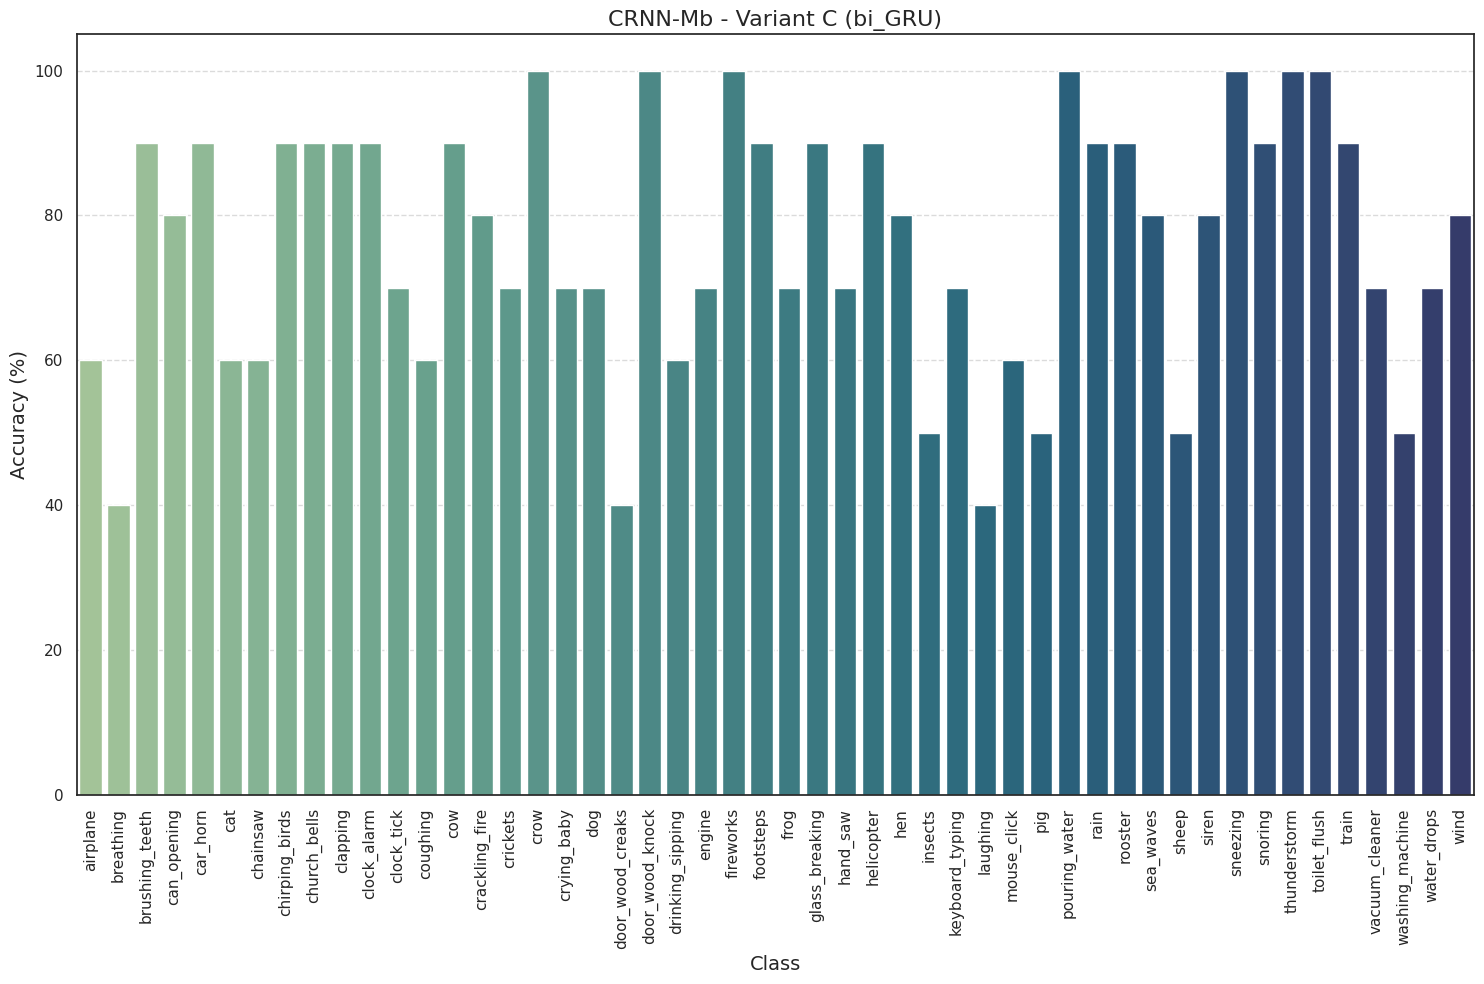

In [36]:
# Load labels
with open('classes.pkl', 'rb') as c:
  classes = pickle.load(c)

fig, ax = plt.subplots(1, 1, sharex=True, figsize=(fig_size[0], fig_size[1]))

sb.barplot(x=classes, y=class_accuracy[0], palette=sb_palette, ax=ax)
ax.set_ylabel("Accuracy (%)", fontsize = 14)
ax.grid(axis="y", linestyle="--", alpha=0.7)
ax.set_title(model_names[0], fontsize=16)

ax.set_xlabel("Class", fontsize=14)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()